### **Classification of SMCA Criteria for Hass Avocado Cultivation in La Ceja, Antioquia**

## **Estuadiantes:** Paula Andrea Cardona Velasquez - Mario Alejandro Celis Torres

## Classification of SMCA Criteria for Hass Avocado Cultivation in *La Ceja, Antioquia*

This Spatial Multi-Criteria Analysis (SMCA) identifies suitable areas for **Hass avocado cultivation** in the municipality of **La Ceja (Antioquia, Colombia)** by integrating **factors** and **constraints** derived from geospatial data.  
The methodology combines **spatial proximity**, **topographic features**, **land use attributes**, and **regulatory restrictions** to support evidence-based decision-making.

### ✅ Factors Included in the Weighted Suitability Model

| No. | Criterion                                 | SMCA Type   | Explanation |
|-----|-------------------------------------------|-------------|-------------|
| 1   | **Slope (% slope, lower = better)**       | **Cost**    | Gentle slopes reduce erosion and facilitate mechanization. Suitability decreases above 20%. |
| 2   | **Proximity to roads**                    | **Benefit** | Close access improves logistics and market connectivity. Suitability drops beyond 2 km. |
| 3   | **Proximity to drainage networks**        | **Benefit** | Enhances irrigation potential. Areas near natural drains are considered more favorable. |
| 4   | **Land cover (reclassified)**             | **Benefit** | Agricultural and pasture land is preferred. Forests and urban areas are less suitable. |
| 5   | **Homogeneous land units (AHT)**          | **Benefit** | Units with favorable soil and terrain conditions increase overall suitability. |
| 6   | **Land vocation (reclassified)**          | **Benefit** | Areas officially designated for permanent crops are prioritized. |

### 🚫 Constraints (Strict Exclusion Zones)

| No. | Criterion                                   | SMCA Type     | Explanation |
|-----|---------------------------------------------|---------------|-------------|
| C1  | **Protected areas (RUNAP)**                 | **Constraint** | National reserves and protected zones. Cultivation is prohibited. |
| C2  | **Proximity to rivers (buffer 30 m)**       | **Constraint** | Buffer zone to protect riparian ecosystems. No cultivation allowed. |
| C3  | **Slopes greater than 20%**                 | **Constraint** | Steep areas are excluded due to high erosion risk and difficulty in management. |
| C4  | **Elevation above 2,900 m a.s.l.**          | **Constraint** | Outside the optimal elevation range for Hass avocado. |
| C5  | **Other restricted land uses**              | **Constraint** | Urban areas, water bodies, or non-agricultural zones as per planning regulations. |

---

### 📌 Notes:

- A **benefit** criterion contributes positively to suitability: higher normalized values (0–100) indicate higher suitability.
- A **cost** criterion contributes negatively: suitability decreases as values increase.
- A **constraint** is binary and strict: these areas are fully excluded from the suitability analysis (set to `-1` and masked visually).

The final suitability maps were classified into four categories:  
**0 = Restricted**, **1 = Low**, **2 = Medium**, **3 = High**, and visualized under multiple weighting scenarios (equal weights, road priority, slope priority, and mixed AHP-based weights).


## 1. Setting the scene
### 1.1. Import libraries

In [139]:
import rasterio
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
import geopandas as gpd
from pathlib import Path
import os
import richdem as rd
import shutil
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.colors as mcolors
import traceback 

## Load Layers for Avocado Suitability Analysis
- **1. AOI**: Study area located in the municipality of La Ceja (Antioquia), selected for its agricultural importance and topographic conditions favorable for Hass avocado cultivation.
- **2. DEM**: Digital Elevation Model representing terrain height in meters above sea level, used for slope, aspect, and drainage analysis.
- **3. RUNAP**: Protected areas officially registered in Colombia’s National Registry of Protected Areas (RUNAP), where agricultural use is restricted.
- **4. Vector cartography**: Vector layers used in the analysis include LVia (road network), Drenaje_L, and Drenaje_R (hydrographic features), to assess accessibility and hydrological influence.
- **5. AHT**: Rural areas with similar conditions in terms of climate, terrain, and soil, useful for identifying homogeneous agricultural zones.
- **6. Conditional agricultural frontier**: Official boundary that defines areas where agriculture is allowed under specific environmental and conservation conditions.
- **7. Land Cover**: Thematic classification of current land use (e.g., forest, agriculture, pasture), used to determine land compatibility with cultivation.
- **8. Land vocation**: Assessment of land’s optimal use based on physical, chemical, and climatic properties, indicating suitability for specific agricultural purposes.

### 1.2. Load raster and shape layers

In [31]:
# Directorio base
base_dir = Path.cwd()
capas = base_dir / "capas"

aoi            = capas / "aoi.shp"
dem            = capas / "DEM.tif"
runap          = capas / "runap.shp"
carto          = capas / "Carto2000_05376_20230505.gpkg"
aht            = capas / "aht.shp"
frontera_cond  = capas / "frontera_cond.shp"
cobertura      = capas / "cobertura.shp"
vocation       = capas / "vocacion.shp"

print("Paths assigned correctly")

# Verificación de archivos
for path in [aoi, dem, runap, carto, aht, frontera_cond, cobertura, vocation]:
    if not path.exists():
        print(f"⚠️ Archivo no encontrado: {path}")
    else:
        print(f"✅ Archivo encontrado: {path.name}")


Paths assigned correctly
✅ Archivo encontrado: aoi.shp
✅ Archivo encontrado: DEM.tif
✅ Archivo encontrado: runap.shp
✅ Archivo encontrado: Carto2000_05376_20230505.gpkg
✅ Archivo encontrado: aht.shp
✅ Archivo encontrado: frontera_cond.shp
✅ Archivo encontrado: cobertura.shp
✅ Archivo encontrado: vocacion.shp


### 1.3 Extraction of Infrastructure Layers and Slope Generation from DEM

This step involves two main tasks:

1. **Vector Layer Extraction**:  
   The **road network** (`LVia`) and **drainage lines** (`Drenaj_L`, `Drenaj_R`) are extracted from a GeoPackage (`Carto2000_05376_20230505.gpkg`) using `GeoPandas`. Each layer is exported as a Shapefile and stored in a designated output directory. These layers are later used to compute proximity maps as part of the SMCA factors.

2. **Slope Calculation from DEM**:  
   The **Digital Elevation Model** (`DEM.tif`) is processed with the `richdem` library to calculate the **slope raster** (in degrees). The result is saved as `pendiente.tif`, representing a topographic cost factor — lower slopes are considered more suitable for Hass avocado cultivation.


In [35]:
# Directorios
base_dir = Path.cwd()
capas = base_dir / "capas"
gpkg_path = capas / "Carto2000_05376_20230505.gpkg"
salida = capas / "lineas_extraidas"
salida.mkdir(exist_ok=True)

# Capas a extraer del GeoPackage
capas_a_extraer = ["LVia", "Drenaj_L", "Drenaj_R"]

print("Extrayendo capas desde el archivo GeoPackage...")
for capa in capas_a_extraer:
    try:
        gdf = gpd.read_file(gpkg_path, layer=capa)
        out_path = salida / f"{capa}.shp"
        gdf.to_file(out_path)
        print(f"Capa '{capa}' exportada como: {out_path.name}")
    except Exception as e:
        print(f"Error al extraer la capa '{capa}': {e}")

# 2. Cálculo de la pendiente desde el DEM

print("\n Calculando pendiente a partir del DEM...")
dem_path = capas / "DEM.tif"
rasters_dir = capas / "rasters"
rasters_dir.mkdir(exist_ok=True)

try:
    dem_rd = rd.LoadGDAL(str(dem_path))
    pendiente = rd.TerrainAttribute(dem_rd, attrib='slope_degrees')

    pendiente_path = rasters_dir / "pendiente.tif"
    rd.SaveGDAL(str(pendiente_path), pendiente)

    print(f"✅ Capa de pendiente guardada como: {pendiente_path.name}")
except Exception as e:
    print(f"❌ Error al calcular la pendiente: {e}")


Extrayendo capas desde el archivo GeoPackage...
Capa 'LVia' exportada como: LVia.shp
Capa 'Drenaj_L' exportada como: Drenaj_L.shp
Capa 'Drenaj_R' exportada como: Drenaj_R.shp

 Calculando pendiente a partir del DEM...
✅ Capa de pendiente guardada como: pendiente.tif


### 1.4 Reproject Layers

In this step, all vector and raster layers are reprojected to a **common projected coordinate reference system (CRS)** to ensure spatial consistency during analysis. This is essential for accurate overlay operations, distance calculations, and raster algebra in the SMCA workflow.


In [37]:
# Reproyección de capas al EPSG:9377
epsg_objetivo = 9377

#Directorios
base_dir = Path.cwd()
capas = base_dir / "capas"
salida = capas / "reproyectado"
salida.mkdir(exist_ok=True)

# Lista de capas a reproyectar: (archivo relativo, nombre de salida, tipo)
capas_procesar = [
    ("runap.shp",                "runap_reproj",       "vector"),
    ("aht.shp",                  "aht_reproj",         "vector"),
    ("frontera_cond.shp",       "frontera_reproj",    "vector"),
    ("cobertura.shp",           "cobertura_reproj",   "vector"),
    ("vocacion.shp",            "vocacion_reproj",    "vector"),
    ("lineas_extraidas/LVia.shp",       "LVia_reproj",       "vector"),
    ("lineas_extraidas/Drenaj_L.shp",   "Drenaj_L_reproj",   "vector"),
    ("lineas_extraidas/Drenaj_R.shp",   "Drenaj_R_reproj",   "vector"),
    ("rasters/pendiente.tif",           "pendiente",         "raster")
]

procesadas = []

# Función para reproyectar capas vectoriales
def reproyectar_vector(ruta_entrada, nombre_salida):
    try:
        gdf = gpd.read_file(capas / ruta_entrada, engine="fiona", encoding="latin1").to_crs(epsg=epsg_objetivo)
        salida_path = salida / f"{nombre_salida}.shp"
        gdf.to_file(salida_path)
        print(f"✅ Reproyectado vectorial: {nombre_salida} → {salida_path.name}")
        procesadas.append(nombre_salida)
    except Exception as e:
        print(f"❌ Error al reproyectar vectorial {nombre_salida}: {e}")

# Función para reproyectar ráster
def reproyectar_raster(ruta_entrada, nombre_salida):
    try:
        entrada_path = capas / ruta_entrada
        salida_path = salida / f"{nombre_salida}.tif"
        with rasterio.open(entrada_path) as src:
            if src.crs.to_epsg() == epsg_objetivo:
                shutil.copy(entrada_path, salida_path)
                print(f"✅ CRS ya es EPSG:{epsg_objetivo}. Copiado: {nombre_salida}.tif")
            else:
                transform, width, height = calculate_default_transform(
                    src.crs, f"EPSG:{epsg_objetivo}", src.width, src.height, *src.bounds
                )
                kwargs = src.meta.copy()
                kwargs.update({
                    "crs": f"EPSG:{epsg_objetivo}",
                    "transform": transform,
                    "width": width,
                    "height": height
                })

                with rasterio.open(salida_path, "w", **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=f"EPSG:{epsg_objetivo}",
                            resampling=Resampling.nearest
                        )
                print(f"✅ Reproyectado ráster: {nombre_salida}.tif")
        procesadas.append(nombre_salida)
    except Exception as e:
        print(f"❌ Error al reproyectar ráster {nombre_salida}: {e}")

# Procesar todas las capas
for archivo, nombre, tipo in capas_procesar:
    if tipo == "vector":
        reproyectar_vector(archivo, nombre)
    elif tipo == "raster":
        reproyectar_raster(archivo, nombre)

# Resumen
print("\n Resumen de capas reproyectadas:")
for nombre in procesadas:
    print(f" - {nombre}")


✅ Reproyectado vectorial: runap_reproj → runap_reproj.shp
✅ Reproyectado vectorial: aht_reproj → aht_reproj.shp


C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 'Tierras de clima medio hÃºmedo, localizadas en filas y vigas dentro del paisaje de montaÃ±a, de relieve ligeramente escarpado con pendientes de 25 a 50%; presenta fenÃ³menos de remociÃ³n en masa en grado ligero. Los suelos se han derivado de rocas metamÃ' of field Observacio has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 182477130.046000004 of field shape_Area of feature 361 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 114049622.474000007 of field shape_Area of feature 1192 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


✅ Reproyectado vectorial: frontera_reproj → frontera_reproj.shp
✅ Reproyectado vectorial: cobertura_reproj → cobertura_reproj.shp
✅ Reproyectado vectorial: vocacion_reproj → vocacion_reproj.shp
✅ Reproyectado vectorial: LVia_reproj → LVia_reproj.shp
✅ Reproyectado vectorial: Drenaj_L_reproj → Drenaj_L_reproj.shp
✅ Reproyectado vectorial: Drenaj_R_reproj → Drenaj_R_reproj.shp
✅ Reproyectado ráster: pendiente.tif

 Resumen de capas reproyectadas:
 - runap_reproj
 - aht_reproj
 - frontera_reproj
 - cobertura_reproj
 - vocacion_reproj
 - LVia_reproj
 - Drenaj_L_reproj
 - Drenaj_R_reproj
 - pendiente


### 1.5 Clip Vector Layers to the Area of Interest (AOI)

Before performing any raster-based processing, the following **vector layers** are clipped to the rural boundary of *La Ceja - Antioquia* using the AOI shapefile (`aoi.shp`). This ensures that all subsequent analyses are spatially restricted to the relevant study area.

| Layer                          | File name             | Purpose of clipping                                                                 |
|-------------------------------|-----------------------|--------------------------------------------------------------------------------------|
| Protected Areas (RUNAP)       | `runap.shp`           | Remove polygons outside the AOI so the exclusion mask only covers relevant territory. |
| Conditional Agricultural Frontier | `frontera_cond.shp` | Ensure that suitability is evaluated only within the legally allowed frontier.       |
| Land-Use Capability           | `capacidad.shp`       | Keep capability classes strictly inside the AOI for accurate reclassification.       |


In [39]:
# EPSG objetivo
epsg_objetivo = 9377

# Directorios
base_dir = Path.cwd()
capas = base_dir / "capas"
entrada = capas / "reproyectado"
salida = capas / "procesado"
salida.mkdir(exist_ok=True)

# Cargar AOI reproyectado
aoi = gpd.read_file(capas / "aoi.shp", engine="fiona", encoding="latin1").to_crs(epsg=epsg_objetivo)

# Lista de capas (vectoriales y ráster) a procesar
capas_procesar = [
                            ("runap_reproj.shp", "runap_clip"),
                            ("aht_reproj.shp", "aht_clip"),
                            ("frontera_reproj.shp", "frontera_clip"),
                            ("cobertura_reproj.shp", "cobertura_clip"),
                            ("vocacion_reproj.shp", "vocacion_clip"),
                            ("LVia_reproj.shp", "LVia_clip"),
                            ("Drenaj_L_reproj.shp", "Drenaj_L_clip"),
                            ("Drenaj_R_reproj.shp", "Drenaj_R_clip"),
]

procesadas = []

# Función para procesar capas
def procesar_capa(ruta_entrada, nombre_salida):
    try:
        if ruta_entrada.endswith(".tif"):
            # Si es ráster, se copia sin recorte
            src = entrada / ruta_entrada
            dst = salida / nombre_salida
            dst.write_bytes(src.read_bytes())
        else:
            # Si es vectorial, se recorta con el AOI
            gdf = gpd.read_file(entrada / ruta_entrada, engine="fiona", encoding="latin1")
            gdf_clip = gpd.overlay(gdf, aoi, how="intersection")
            salida_path = salida / f"{nombre_salida}.shp"
            gdf_clip.to_file(salida_path)
            print(f"✅ Clip: {nombre_salida} → {salida_path.name}")
        procesadas.append(nombre_salida)
    except Exception as e:
        print(f"❌ Error al procesar {nombre_salida}: {e}")

# Procesar todas las capas
for archivo, nombre in capas_procesar:
    procesar_capa(archivo, nombre)

# Resumen
print("\n Resumen de capas recortadas o copiadas:")
for nombre in procesadas:
    print(f" - {nombre}")

C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'OBJECTID' to 'OBJECTID_1'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000

✅ Clip: runap_clip → runap_clip.shp


C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Leng' to 'SHAPE_Le_1'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Area' to 'SHAPE_Ar_1'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 'Tierras de clima medio hÃÂºmedo, localizadas en filas y vigas dentro del paisaje de montaÃÂ±a, de relieve ligeramente escarpado con pendientes de 25 a 50%; presenta fenÃÂ³menos de remociÃÂ³n en masa en grado ligero. Los suelos se han derivado de roca' of field Observacio has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Ar_1 of feature 0 not successfully written. Possibly due to too larger numbe

✅ Clip: aht_clip → aht_clip.shp


C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Leng' to 'SHAPE_Le_1'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Area' to 'SHAPE_Ar_1'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Ar_1 of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Ar_1 of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Ar_1 of feature 2 not successfully written. Possibly due to too 

✅ Clip: frontera_clip → frontera_clip.shp


C:\Users\mario.celis\AppData\Local\Temp\ipykernel_34364\2665821745.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_clip.to_file(salida_path)
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Leng_1' to 'SHAPE_Leng'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Area_1' to 'SHAPE_Area'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Leng_2' to 'SHAPE_Le_1'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Area_2' to 'SHAPE_Ar_1'
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Ar_1 of feature 0 no

✅ Clip: cobertura_clip → cobertura_clip.shp
✅ Clip: vocacion_clip → vocacion_clip.shp


C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 3 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis

✅ Clip: LVia_clip → LVia_clip.shp


C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 3 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis

✅ Clip: Drenaj_L_clip → Drenaj_L_clip.shp
✅ Clip: Drenaj_R_clip → Drenaj_R_clip.shp

 Resumen de capas recortadas o copiadas:
 - runap_clip
 - aht_clip
 - frontera_clip
 - cobertura_clip
 - vocacion_clip
 - LVia_clip
 - Drenaj_L_clip
 - Drenaj_R_clip


C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 132666735.724000007 of field SHAPE_Area of feature 3 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\mario.celis

### **1.6 Rasterization of Clipped Vector Layers Using the DEM as Template**

This step involves two key sub-processes to convert vector data into raster format, aligned with the spatial properties of the DEM:

#### **Attribute Inspection**

Before rasterizing, all clipped shapefiles were reviewed to identify the relevant attribute fields.  
This ensures the correct field is selected for encoding raster values—especially important for categorical layers used in reclassification or constraint masking.

#### **Rasterization Process**

Each vector layer is rasterized using the DEM as a spatial template (same resolution, extent, CRS, and affine transform).  
Two types of rasterization are performed:

- **Binary masks** (`LVia`, `Drenaj_L`, `Drenaj_R`, `runap`):  
  Presence is encoded as `1`, absence as `0`. These rasters are used for proximity analysis and constraint masking.

- **Categorical layers**:
  - `aht` → `VPotencial`: Represents land productivity potential within homogeneous land units.
  - `cobertura` → `codigo`: Land cover classes, used for suitability reclassification.
  - `vocacion` → `UCVocacion`: Official soil vocation, indicating permitted or optimal land uses.
  - `frontera_cond` → `tipo_front`: Defines zones within the conditional agricultural frontier.

All output rasters are saved in **GeoTIFF** format and will be used in subsequent SMCA steps such as reclassification, masking, and suitability scoring.


In [40]:
# Revisión de atributos de shapefiles recortados

from pathlib import Path
import geopandas as gpd

# Ruta a la carpeta con shapefiles recortados
procesado_dir = Path.cwd() / "capas" / "procesado"

# Buscar todos los shapefiles en la carpeta
shapefiles = list(procesado_dir.glob("*.shp"))

print(" Revisión de columnas por capa:\n")

# Iterar sobre los shapefiles y mostrar sus columnas
for shp_path in shapefiles:
    try:
        gdf = gpd.read_file(shp_path)
        print(f"{shp_path.name}")
        print("Columnas:")
        for col in gdf.columns:
            print(f"   - {col}")
        print("─" * 50)
    except Exception as e:
        print(f"❌ Error al leer {shp_path.name}: {e}")


 Revisión de columnas por capa:

aht_clip.shp
Columnas:
   - fid
   - OBJECTID_1
   - Divipola
   - SIMBOLO
   - UCSuelo
   - CLASE
   - UClimatica
   - PENDIENTE
   - FPendiente
   - EHidrica
   - EEolica
   - ERemosion
   - INUNDACION
   - Encharcami
   - FNFreatico
   - PEfectiva
   - HDensicos
   - FGPerfil
   - PSuperfici
   - LRocosidad
   - LSodicidad
   - LSalinidad
   - CYeso
   - DArtificia
   - AIntercamb
   - Miscelaneo
   - VPotencial
   - Observacio
   - Fecha
   - TRelieve
   - MParental
   - CSimbolo
   - AREA
   - Shape_Leng
   - Shape_Area
   - OBJECTID_2
   - MpCodigo
   - MpNombre
   - MpArea
   - MpNorma
   - MpCategor
   - SHAPE_Le_1
   - SHAPE_Ar_1
   - MpAltitud
   - Restriccio
   - Depto
   - geometry
──────────────────────────────────────────────────
cobertura_clip.shp
Columnas:
   - OBJECTID_1
   - codigo
   - leyenda
   - insumo
   - apoyo
   - confiabili
   - cambio
   - nivel_1
   - nivel_2
   - nivel_3
   - nivel_4
   - nivel_5
   - nivel_6
   - area_ha
 

In [159]:
# Rutas de trabajo
base_dir = Path.cwd()
capas = base_dir / "capas"
shapes = capas / "procesado"
rasters = capas / "rasters"
rasters.mkdir(parents=True, exist_ok=True)

# Plantilla base: DEM
dem_path = capas / "DEM.tif"
with rasterio.open(dem_path) as src:
    dem_meta = src.meta.copy()
    dem_shape = src.shape
    dem_transform = src.transform
    dem_crs = src.crs

# Función para rasterizar shapefiles
def rasterizar_shapefile(shapefile_path, output_raster_path, dtype="uint8", field=None, nodata=None):
    gdf = gpd.read_file(shapefile_path).to_crs(dem_crs)

    # DEPURACIÓN para ver por qué no sale vocación
    print(f"\n📂 Leyendo: {shapefile_path.name}")
    print(f"🟦 Número de geometrías: {len(gdf)}")
    if field:
        if field not in gdf.columns:
            print(f"🚫 El campo '{field}' no existe en {shapefile_path.name}")
        else:
            print(f"🔎 Valores únicos en '{field}':\n{gdf[field].unique()}")
            print(f"❗ Valores nulos en '{field}': {gdf[field].isna().sum()}")
    print(f"🗺️ Extensión del shapefile: {gdf.total_bounds}")
    print(f"🗺️ Extensión del DEM: {[dem_transform[2], dem_transform[2] + dem_transform[0]*dem_shape[1], dem_transform[5] + dem_transform[4]*dem_shape[0], dem_transform[5]]}")

    if gdf.empty:
        print(f"⚠️ {shapefile_path.name} está vacía, se omite.")
        return

    if field is not None:
        if field not in gdf.columns:
            print(f"❌ El campo '{field}' no existe en {shapefile_path.name}, se omite.")
            return
        if gdf[field].dtype == 'object':
            gdf[field], _ = gdf[field].factorize()
        shapes_gen = ((geom, val) for geom, val in zip(gdf.geometry, gdf[field]))
    else:
        shapes_gen = ((geom, 1) for geom in gdf.geometry)

    raster = rasterize(
        shapes=shapes_gen,
        out_shape=dem_shape,
        transform=dem_transform,
        fill=nodata if nodata is not None else 0,
        dtype=dtype
    )

    meta = dem_meta.copy()
    meta.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": dtype,
        "nodata": nodata
    })

    with rasterio.open(output_raster_path, "w", **meta) as dst:
        dst.write(raster, 1)

    print(f"✅ Raster creado: {output_raster_path.name}")

# Rasterización de capas binarias (presencia = 1)
máscaras_binarias = [
    ("runap_clip.shp",       "runap.tif"),
    ("LVia_clip.shp",        "lvia.tif"),
    ("Drenaj_L_clip.shp",    "drenaj_l.tif"),
    ("Drenaj_R_clip.shp",    "drenaj_r.tif")
]

print("Rasterizando capas binarias...\n")
for shp_name, tif_name in máscaras_binarias:
    print(f"🔄 Procesando capa binaria: {shp_name}")
    try:
        rasterizar_shapefile(
            shapes / shp_name,
            rasters / tif_name,
            dtype="uint8",
            field=None,
            nodata=0
        )
    except Exception as e:
        print(f"❌ Error al rasterizar {shp_name}: {e}")
        traceback.print_exc()

# Rasterización de capas categóricas con atributo
capas_valoradas = [
    ("aht_clip.shp",         "aht.tif",          "VPotencial"),
    ("cobertura_clip.shp",   "cobertura.tif",    "codigo"),
    ("vocacion_clip.shp",    "vocacion.tif",     "UCVocacion"),
    ("frontera_clip.shp",    "frontera_cond.tif","tipo_front")
]

print("\nRasterizando capas categóricas con atributos...\n")
for shp_name, tif_name, field in capas_valoradas:
    print(f"🔄 Procesando capa categórica: {shp_name} (atributo: {field})")
    try:
        rasterizar_shapefile(
            shapes / shp_name,
            rasters / tif_name,
            dtype="int16",
            field=field,
            nodata=-9999
        )
    except Exception as e:
        print(f"❌ Error al rasterizar {shp_name}: {e}")
        traceback.print_exc()


Rasterizando capas binarias...

🔄 Procesando capa binaria: runap_clip.shp

📂 Leyendo: runap_clip.shp
🟦 Número de geometrías: 4
🗺️ Extensión del shapefile: [4725603.86305955 2214230.29306737 4738828.0094     2228910.64076218]
🗺️ Extensión del DEM: [4722364.0, 4738848.0, 2210504.0, 2229208.0]
✅ Raster creado: runap.tif
🔄 Procesando capa binaria: LVia_clip.shp

📂 Leyendo: LVia_clip.shp
🟦 Número de geometrías: 3685
🗺️ Extensión del shapefile: [4722574.2308     2211411.3596     4738164.69037403 2229099.42943693]
🗺️ Extensión del DEM: [4722364.0, 4738848.0, 2210504.0, 2229208.0]
✅ Raster creado: lvia.tif
🔄 Procesando capa binaria: Drenaj_L_clip.shp

📂 Leyendo: Drenaj_L_clip.shp
🟦 Número de geometrías: 7659
🗺️ Extensión del shapefile: [4722434.7668     2210597.3943     4738745.5982     2229159.15136035]
🗺️ Extensión del DEM: [4722364.0, 4738848.0, 2210504.0, 2229208.0]
✅ Raster creado: drenaj_l.tif
🔄 Procesando capa binaria: Drenaj_R_clip.shp

📂 Leyendo: Drenaj_R_clip.shp
🟦 Número de geometrí

### 1.7 Reclassification of Raster Layers for Suitability Analysis

This step converts the categorical values of selected raster layers into standardized **suitability scores** for the Spatial Multi-Criteria Analysis (SMCA). These scores reflect the relative aptitude of each area for **Hass avocado cultivation**, based on agronomic knowledge and land-use planning criteria.

#### Reclassification rules:

- **AHT (`VPotencial`)** – Agricultural Potential:  
  Based on the observed codes and descriptions, we apply the following suitability scores:

  | VPOTENCIAL Code | Description (from Observations)                     | Suitability Score |
  |------------------|------------------------------------------------------|-------------------|
  | 1                | High potential for perennial crops (e.g. Hass)      | 5                 |
  | 2                | Moderate potential                                  | 3                 |
  | 3                | Low potential or conditional use                    | 1                 |
  | NaN or others    | Not defined / unsuitable                            | 0                 |

- **Land Cover (`codigo`)** – Based on compatible land use types:

  | `codigo` | Land Cover Description        | Suitability Score |
  |----------|-------------------------------|-------------------|
  | 111      | Pastures                      | 5                 |
  | 112      | Secondary vegetation          | 4                 |
  | 121      | Bare soil / no vegetation     | 3                 |
  | 142, 243 | Agricultural mosaics          | 3                 |
  | 131, 221 | Forest / natural vegetation   | 1                 |
  | 511      | Water bodies                  | 0                 |
  | 3231...  | Urban / built-up              | 0                 |

- **Land Use Vocación (`UCVocacion`)** – Agricultural vocation class:

  | UCVocacion | Description                            | Suitability Score |
  |------------|----------------------------------------|-------------------|
  | CPSf       | Suitable for permanent crops           | 5                 |
  | CTIf       | Transitional: can support some crops   | 3                 |
  | ZU         | Urban or excluded use                  | 0                 |
  | FPP/FPR    | Forest production / protection zones   | 1                 |
  | Others     | Not suitable or undefined              | 0                 |

This standardization ensures consistency across inputs and enables weighted overlay in later stages of the SMCA.


In [165]:
# EPSG objetivo
epsg_objetivo = 9377

# Rutas de trabajo
base_dir = Path.cwd()
capas = base_dir / "capas"
shapes = capas / "procesado"
rasters = capas / "rasters"

# Rutas de entrada/salida
raster_aht = rasters / "aht.tif"
raster_cobertura = rasters / "cobertura.tif"
raster_vocacion = rasters / "vocacion.tif"

salida_aht = rasters / "RECLASIFICADO_AHT.tif"
salida_cobertura = rasters / "RECLASIFICADO_COBERTURA.tif"
salida_vocacion = rasters / "RECLASIFICADO_VOCACION.tif"

# Mapas de reclasificación
mapa_vpotencial = {
    1: 5,
    2: 3,
    3: 1
}

mapa_cobertura = {
    111: 5,
    112: 4,
    121: 3,
    142: 3, 243: 3,
    131: 1, 221: 1,
    511: 0,
    3231: 0
}

# ATENCIÓN: este es el nuevo mapa con códigos numéricos asignados por factorize
mapa_vocacion_codificada = {
    1: 5,   # CPSf
    2: 3,   # CTIf
    4: 1,   # FPP
    5: 1,   # FPR
    7: 0    # ZU
    # Otros se asignan automáticamente a 0
}

# Función de reclasificación para valores enteros
def reclasificar_raster(entrada, salida, mapa_reclasificacion):
    with rasterio.open(entrada) as src:
        data = src.read(1)
        meta = src.meta.copy()

    reclasificada = np.zeros_like(data, dtype=np.uint8)

    for valor_original, valor_reclasificado in mapa_reclasificacion.items():
        reclasificada[data == valor_original] = valor_reclasificado

    meta.update(dtype='uint8', count=1, nodata=0)

    with rasterio.open(salida, 'w', **meta) as dst:
        dst.write(reclasificada, 1)

    print(f"✅ Raster reclasificado guardado: {salida.name}")

# Ejecutar reclasificaciones
reclasificar_raster(raster_aht, salida_aht, mapa_vpotencial)
reclasificar_raster(raster_cobertura, salida_cobertura, mapa_cobertura)
reclasificar_raster(raster_vocacion, salida_vocacion, mapa_vocacion_codificada)


✅ Raster reclasificado guardado: RECLASIFICADO_AHT.tif
✅ Raster reclasificado guardado: RECLASIFICADO_COBERTURA.tif
✅ Raster reclasificado guardado: RECLASIFICADO_VOCACION.tif


## 2. Factors

### 2.1 Compute Euclidean Distance to Roads and Rivers

In this step, we calculate the **Euclidean distance** from each raster cell to the nearest road or river pixel using the `distance_transform_edt()` function from `scipy.ndimage`.

Because our road (`lvia.tif`) and drainage (`drenaj_l.tif`, `drenaj_r.tif`) layers are binary rasters (where `1` indicates presence and `0` absence), we first **invert the binary values** to compute distance from the features (i.e., distance from where the value is 1).

The output distance rasters are initially in **pixel units**, and then converted to **map units (meters)** using the pixel size extracted from the affine transformation of the DEM. These distance layers serve as **benefit factors** in the SMCA, where **shorter distances imply higher suitability**.


✅ Distancias euclidianas calculadas en metros.


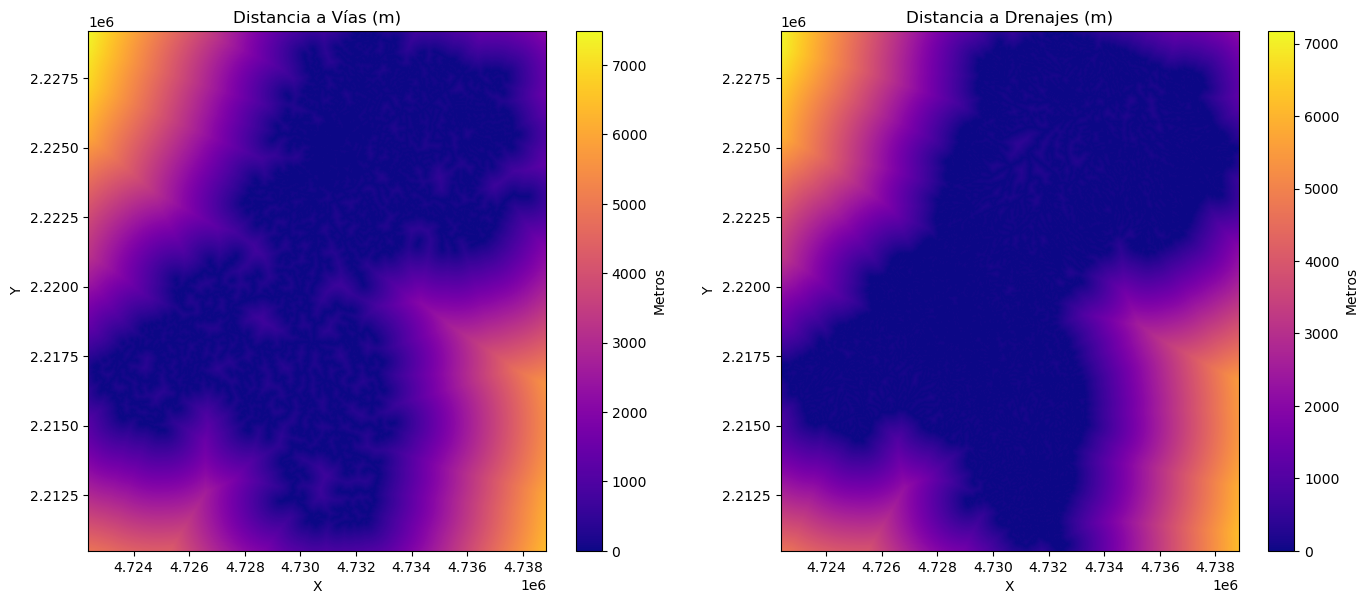

In [82]:
# Cálculo de distancias euclidianas a vías y drenajes
# Rutas a los rásters
rasters_dir = Path.cwd() / "capas" / "rasters"
lvia_path = rasters_dir / "lvia.tif"
drenaj_l_path = rasters_dir / "drenaj_l.tif"
drenaj_r_path = rasters_dir / "drenaj_r.tif"

# Leer raster de vías
with rasterio.open(lvia_path) as src:
    roads = src.read(1)
    transform = src.transform
    bounds = src.bounds
    pixel_size = transform[0]

# Leer y combinar drenajes
with rasterio.open(drenaj_l_path) as src:
    drenaj_l = src.read(1)

with rasterio.open(drenaj_r_path) as src:
    drenaj_r = src.read(1)

rivers = np.clip(drenaj_l + drenaj_r, 0, 1)

# Invertir para distancia (hacia los ceros)
roads_inv = roads == 0
rivers_inv = rivers == 0

# Calcular distancias en metros
dist_roads_m = distance_transform_edt(roads_inv) * pixel_size
dist_rivers_m = distance_transform_edt(rivers_inv) * pixel_size

print("✅ Distancias euclidianas calculadas en metros.")

# Visualización de distancias
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

img1 = axs[0].imshow(dist_roads_m, cmap='plasma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[0].set_title("Distancia a Vías (m)")
plt.colorbar(img1, ax=axs[0], label="Metros")

img2 = axs[1].imshow(dist_rivers_m, cmap='plasma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[1].set_title("Distancia a Drenajes (m)")
plt.colorbar(img2, ax=axs[1], label="Metros")

for ax in axs:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(False)

plt.tight_layout()
plt.show()


## 2.2. Factor Normalisation for Spatial Multi-Criteria Analysis (SMCA)

To integrate multiple spatial layers with different units and scales, all factors were converted to a common suitability scale ranging from **0 to 100**, where:

- **100** = most suitable (ideal condition)  
- **0** = least suitable (unacceptable condition)

This standardisation ensures that all criteria contribute comparably to the weighted overlay model.

### Normalisation logic applied for each factor:

#### 1. Categorical Factors (Suitability Classes)

The following layers represent thematic or land use constraints:

- **Agricultural Potential (AHT)**
- **Land Cover**
- **Land Use Vocation**

These were originally reclassified into a discrete suitability scale from **0 to 5**, based on expert judgement and land-use compatibility.

To ensure consistency with continuous factors, these values were **linearly rescaled to a 0–100 scale** using the formula:

Suitability_100 = (Reclassified_Value / 5) × 100

#### 2. Proximity to Roads (Benefit Factor)

- **Type**: Benefit → shorter distances are better  
- **Rationale**: Proximity to roads improves access for transportation of crops, inputs, and machinery  
- **Normalisation method**: Linear benefit transformation  
- **Thresholds**:
  - 0 m from road → suitability = 100  
  - ≥ 2000 m → suitability = 0  
  - Linearly decreasing suitability between 0–2000 m

#### 3. Proximity to Rivers (Benefit Factor)

- **Type**: Benefit → shorter distances are better  
- **Rationale**: Access to water bodies ensures irrigation potential  
- **Normalisation method**: Linear benefit transformation  
- **Thresholds**:
  - 0 m from river → suitability = 100  
  - ≥ 2000 m → suitability = 0  
  - Linearly decreasing suitability between 0–2000 m

#### 4. Slope (optional)

- **Type**: Cost → lower slope values are better  
- **Rationale**: Steeper slopes increase erosion risk and reduce mechanisation viability  
- **Normalisation method**: Linear cost transformation  
- **Thresholds**:
  - 0% slope → suitability = 100  
  - ≥ 20% slope → suitability = 0  
  - Linearly decreasing suitability between 0–20%

All resulting layers are now expressed on a **0–100 suitability scale** and are ready to be integrated into the SMCA weighted overlay model.


In [169]:
# EPSG objetivo
epsg_objetivo = 9377

# Rutas
rasters = Path.cwd() / "capas" / "rasters"

capas_reclasificadas = [
    ("RECLASIFICADO_AHT.tif", "RECLASIFICADO_AHT_100.tif"),
    ("RECLASIFICADO_COBERTURA.tif", "RECLASIFICADO_COBERTURA_100.tif"),
    ("RECLASIFICADO_VOCACION.tif", "RECLASIFICADO_VOCACION_100.tif"),
]

for nombre_in, nombre_out in capas_reclasificadas:
    entrada = rasters / nombre_in
    salida = rasters / nombre_out

    with rasterio.open(entrada) as src:
        data = src.read(1)
        meta = src.meta.copy()

    # Escalar de 0–5 a 0–100
    data_100 = (data.astype("float32") / 5.0) * 100
    meta.update(dtype="float32", nodata=0)

    with rasterio.open(salida, "w", **meta) as dst:
        dst.write(data_100, 1)

    print(f"✅ Escalado guardado: {nombre_out}")


✅ Escalado guardado: RECLASIFICADO_AHT_100.tif
✅ Escalado guardado: RECLASIFICADO_COBERTURA_100.tif
✅ Escalado guardado: RECLASIFICADO_VOCACION_100.tif


In [171]:
# Normalización de capas para análisis SMCA (La Ceja, Antioquia)

# Rutas
rasters_dir = Path.cwd() / "capas" / "rasters"
pendiente_path = rasters_dir / "pendiente.tif"
lvia_path = rasters_dir / "lvia.tif"
drenaj_l_path = rasters_dir / "drenaj_l.tif"
drenaj_r_path = rasters_dir / "drenaj_r.tif"

# Cargar pendiente
with rasterio.open(pendiente_path) as src:
    pendiente = src.read(1)
    transform = src.transform
    bounds = src.bounds
    pixel_size = transform[0]
    profile = src.profile

# Cargar y combinar drenajes
with rasterio.open(drenaj_l_path) as src:
    drenaj_l = src.read(1)
with rasterio.open(drenaj_r_path) as src:
    drenaj_r = src.read(1)

rivers = np.clip(drenaj_l + drenaj_r, 0, 1)

# Cargar raster de vías
with rasterio.open(lvia_path) as src:
    roads = src.read(1)

# Calcular distancias euclidianas
roads_inv = roads == 0
rivers_inv = rivers == 0

dist_roads_m = distance_transform_edt(roads_inv) * pixel_size
dist_rivers_m = distance_transform_edt(rivers_inv) * pixel_size

# Normalización de factores a escala 0–100

def normalise_slope_cost(slope_array, threshold=20.0):
    slope_clipped = np.clip(slope_array, 0, threshold)
    norm = 100 * (threshold - slope_clipped) / threshold
    return np.clip(norm, 0, 100)

def normalise_proximity(dist_array, threshold=2000.0):
    clipped = np.clip(dist_array, 0, threshold)
    norm = 100 * (1 - clipped / threshold)
    return np.clip(norm, 0, 100)

# Aplicar normalización
slope_norm = normalise_slope_cost(pendiente, threshold=20.0)
print("✅ Pendiente normalizada (0–100): >20% = no apto (0)")

road_proximity_norm = normalise_proximity(dist_roads_m, threshold=2000)
print("✅ Proximidad a vías normalizada (0–100): cerca = mejor")

river_proximity_norm = normalise_proximity(dist_rivers_m, threshold=2000)
print("✅ Proximidad a drenajes normalizada (0–100): cerca = mejor")

# Guardar capas normalizadas
output_norm = rasters_dir / "normalizados"
output_norm.mkdir(exist_ok=True)

def guardar_raster(array, nombre_salida):
    output_path = output_norm / f"{nombre_salida}.tif"
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(array.astype("float32"), 1)
    print(f"📝 Guardado: {nombre_salida}.tif")

guardar_raster(slope_norm, "slope_norm")
guardar_raster(road_proximity_norm, "roads_norm")
guardar_raster(river_proximity_norm, "rivers_norm")

print("Capas normalizadas guardadas en la carpeta 'normalizados'.")


✅ Pendiente normalizada (0–100): >20% = no apto (0)
✅ Proximidad a vías normalizada (0–100): cerca = mejor
✅ Proximidad a drenajes normalizada (0–100): cerca = mejor
📝 Guardado: slope_norm.tif
📝 Guardado: roads_norm.tif
📝 Guardado: rivers_norm.tif
Capas normalizadas guardadas en la carpeta 'normalizados'.


## 2.3. Visual Comparison of Raw and Normalised Factors

To ensure the quality and consistency of the preprocessing steps, a side-by-side visual comparison was carried out for each factor layer before and after normalisation or scaling.

This comparison serves two purposes:

- To verify that the spatial patterns and logic of the transformations are consistent with agronomic expectations.
- To confirm that all layers are correctly expressed on the same 0–100 suitability scale for integration into the SMCA model.

### Visualised Layers:

#### 1. Continuous Factors (Raw vs. Normalised)
- **Slope**  
  - `pendiente.tif` (raw slope in %)  
  - `slope_norm.tif` (normalised suitability, 0–100)

- **Proximity to Roads**  
  - `DIST_LVIA.tif` (distance in meters)  
  - `roads_norm.tif` (normalised suitability, 0–100)

- **Proximity to Rivers**  
  - `DIST_DRENAJES.tif` (distance in meters)  
  - `rivers_norm.tif` (normalised suitability, 0–100)

#### 2. Categorical Factors (Reclassified vs. Rescaled)
- **Agricultural Potential (AHT)**  
  - `aht.tif` (raw thematic codes)  
  - `RECLASIFICADO_AHT_100.tif` (scaled suitability, 0–100)

- **Land Cover**  
  - `cobertura.tif` (raw land cover codes)  
  - `RECLASIFICADO_COBERTURA_100.tif` (scaled suitability, 0–100)

- **Land Use Vocation**  
  - `vocacion.tif` (raw land use classes)  
  - `RECLASIFICADO_VOCACION_100.tif` (scaled suitability, 0–100)

Each pair of layers was displayed side-by-side using pseudocolor maps to visually assess the effect of the transformation and ensure that suitability increases or decreases in the expected spatial regions.

These visual checks confirmed that the transformations were applied correctly and that all layers are now on a common, interpretable scale ready for integration in the final suitability model.



📈 Rango visual de pendiente ajustado: 0.78–49.28 %


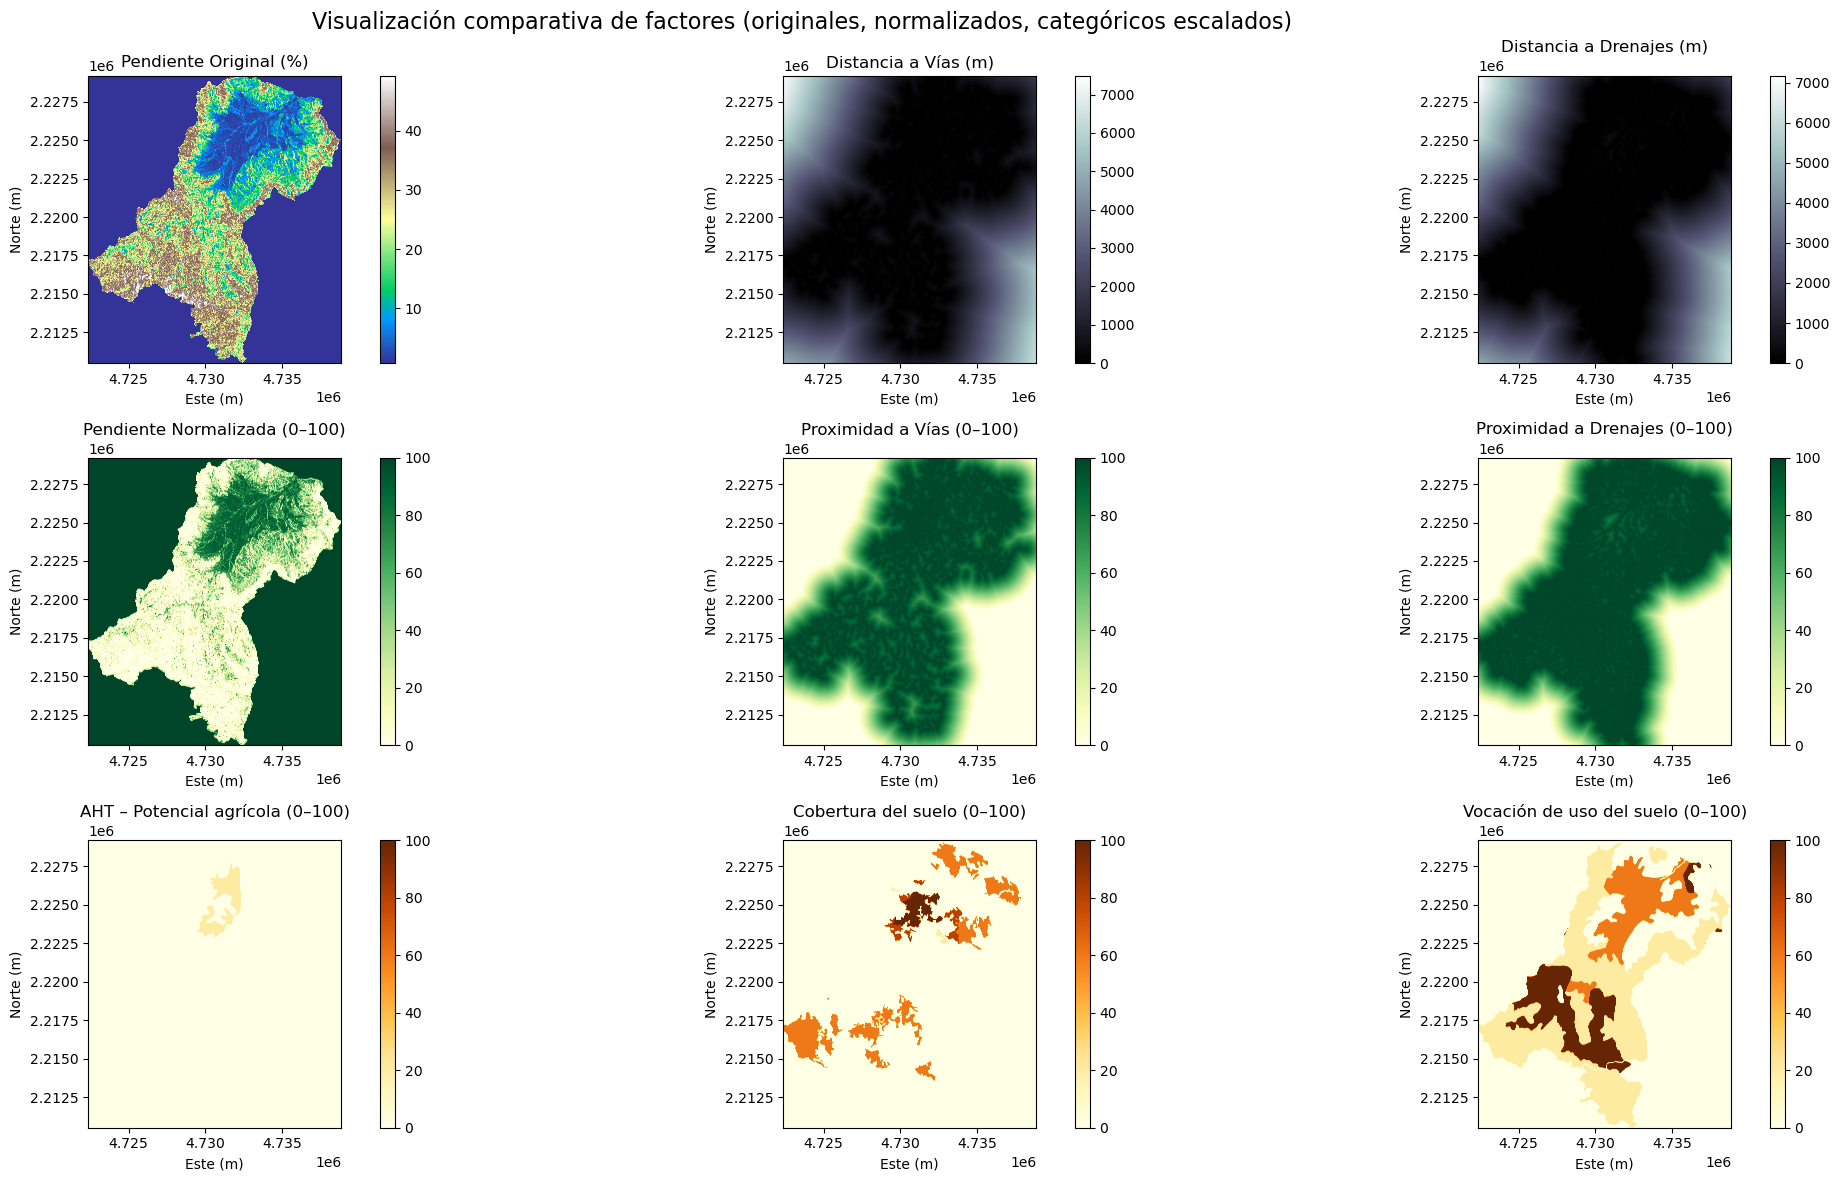

In [172]:
# Visualización de factores originales, normalizados y escalados (SMCA - La Ceja)

from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# Rutas
general_dir = Path.cwd() / "capas"
rasters_dir = general_dir / "rasters"
norm_dir = rasters_dir / "normalizados"

# Cargar capas originales
with rasterio.open(rasters_dir / "pendiente.tif") as src:
    slope = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

with rasterio.open(rasters_dir / "lvia.tif") as src:
    roads = src.read(1)
    transform = src.transform
    pixel_size = transform[0]

with rasterio.open(rasters_dir / "drenaj_l.tif") as src:
    drenaj_l = src.read(1)
with rasterio.open(rasters_dir / "drenaj_r.tif") as src:
    drenaj_r = src.read(1)

rivers = np.clip(drenaj_l + drenaj_r, 0, 1)

# Calcular distancias euclidianas
dist_roads_m = distance_transform_edt(roads == 0) * pixel_size
dist_rivers_m = distance_transform_edt(rivers == 0) * pixel_size

# Cargar capas normalizadas (0–100)
with rasterio.open(norm_dir / "slope_norm.tif") as src:
    slope_norm = src.read(1)
with rasterio.open(norm_dir / "roads_norm.tif") as src:
    road_proximity_norm = src.read(1)
with rasterio.open(norm_dir / "rivers_norm.tif") as src:
    river_proximity_norm = src.read(1)

# Cargar capas categóricas escaladas (0–100)
with rasterio.open(rasters_dir / "RECLASIFICADO_AHT_100.tif") as src:
    aht_100 = src.read(1)
with rasterio.open(rasters_dir / "RECLASIFICADO_COBERTURA_100.tif") as src:
    cobertura_100 = src.read(1)
with rasterio.open(rasters_dir / "RECLASIFICADO_VOCACION_100.tif") as src:
    vocacion_100 = src.read(1)

# Ajustar escala visual de pendiente
slope_min = np.percentile(slope[slope > 0], 2)
slope_max = np.percentile(slope[slope > 0], 98)
print(f"📈 Rango visual de pendiente ajustado: {slope_min:.2f}–{slope_max:.2f} %")

# Figura de 9 paneles: 3 filas x 3 columnas
fig, axs = plt.subplots(3, 3, figsize=(22, 12))
plt.suptitle("Visualización comparativa de factores (originales, normalizados, categóricos escalados)", fontsize=16)

# Fila 1: Factores originales continuos ---
im1 = axs[0, 0].imshow(slope, cmap="terrain", extent=extent, origin="upper", vmin=slope_min, vmax=slope_max)
axs[0, 0].set_title("Pendiente Original (%)")
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(dist_roads_m, cmap="bone", extent=extent, origin="upper")
axs[0, 1].set_title("Distancia a Vías (m)")
plt.colorbar(im2, ax=axs[0, 1])

im3 = axs[0, 2].imshow(dist_rivers_m, cmap="bone", extent=extent, origin="upper")
axs[0, 2].set_title("Distancia a Drenajes (m)")
plt.colorbar(im3, ax=axs[0, 2])

# Fila 2: Factores normalizados (0–100) ---
im4 = axs[1, 0].imshow(slope_norm, cmap="YlGn", extent=extent, origin="upper", vmin=0, vmax=100)
axs[1, 0].set_title("Pendiente Normalizada (0–100)")
plt.colorbar(im4, ax=axs[1, 0])

im5 = axs[1, 1].imshow(road_proximity_norm, cmap="YlGn", extent=extent, origin="upper", vmin=0, vmax=100)
axs[1, 1].set_title("Proximidad a Vías (0–100)")
plt.colorbar(im5, ax=axs[1, 1])

im6 = axs[1, 2].imshow(river_proximity_norm, cmap="YlGn", extent=extent, origin="upper", vmin=0, vmax=100)
axs[1, 2].set_title("Proximidad a Drenajes (0–100)")
plt.colorbar(im6, ax=axs[1, 2])

# Fila 3: Capas categóricas escaladas (0–100) ---
im7 = axs[2, 0].imshow(aht_100, cmap="YlOrBr", extent=extent, origin="upper", vmin=0, vmax=100)
axs[2, 0].set_title("AHT – Potencial agrícola (0–100)")
plt.colorbar(im7, ax=axs[2, 0])

im8 = axs[2, 1].imshow(cobertura_100, cmap="YlOrBr", extent=extent, origin="upper", vmin=0, vmax=100)
axs[2, 1].set_title("Cobertura del suelo (0–100)")
plt.colorbar(im8, ax=axs[2, 1])

im9 = axs[2, 2].imshow(vocacion_100, cmap="YlOrBr", extent=extent, origin="upper", vmin=0, vmax=100)
axs[2, 2].set_title("Vocación de uso del suelo (0–100)")
plt.colorbar(im9, ax=axs[2, 2])

# Ajustes comunes
for ax in axs.flat:
    ax.set_xlabel("Este (m)")
    ax.set_ylabel("Norte (m)")
    ax.grid(False)

plt.tight_layout()
plt.show()

In [175]:
print("📏 Raster shapes (rows, cols):\n")

print(f"Pendiente normalizada:         {slope_norm.shape}")
print(f"Proximidad a vías:             {road_proximity_norm.shape}")
print(f"Proximidad a drenajes:         {river_proximity_norm.shape}")
print(f"AHT (potencial agrícola):      {aht_100.shape}")
print(f"Cobertura del suelo:           {cobertura_100.shape}")
print(f"Vocación de uso del suelo:     {vocacion_100.shape}")

📏 Raster shapes (rows, cols):

Pendiente normalizada:         (9352, 8242)
Proximidad a vías:             (9352, 8242)
Proximidad a drenajes:         (9352, 8242)
AHT (potencial agrícola):      (9352, 8242)
Cobertura del suelo:           (9352, 8242)
Vocación de uso del suelo:     (9352, 8242)


## 3. Restrictions

In [179]:
# Ruta al GeoPackage de cartografía base 1:25,000 (La Ceja, Antioquia)
carto_local_path = Path.cwd() / "capas" / "Carto2000_05376_20230505.gpkg"

# Cargar la capa de red de drenaje (líneas)
gdf_drenajes = gpd.read_file(carto_local_path, layer="Drenaj_L")


### 3.1. Apply a 30-Metre Buffer to the River Layer

Prepare the riparian buffer zone, which will be used later as a constraint in the suitability analysis.
The result is a new GeoDataFrame (`gdf_rivers_buffered`) containing the buffered geometries, ready for rasterisation.


In [187]:
# Reproyectar la capa de drenajes (líneas) al CRS del DEM si es necesario
if gdf_drenajes.crs != dem_meta['crs']:
    gdf_drenajes = gdf_drenajes.to_crs(dem_meta['crs'])
    print("✅ Capa de drenajes reproyectada al CRS del DEM.")

# Crear un buffer de 30 metros alrededor de los drenajes
gdf_rivers_buffered = gdf_drenajes.copy()
gdf_rivers_buffered["geometry"] = gdf_drenajes.buffer(30)

print("✅ Buffer de 30 metros aplicado a los drenajes.")


✅ Buffer de 30 metros aplicado a los drenajes.


### 3.2. Rasterise the Buffered Rivers
Convert the vector buffer zone around rivers into a raster format, aligned with the Digital Elevation Model (DEM).

- The rasterisation process assigns a value of `1` to all pixels within the buffered river areas, and `0` elsewhere.
- The **output shape** and **spatial transform** are inherited from the DEM to ensure perfect alignment between all raster layers.
- This binary raster will be used later to enforce the **riparian buffer constraint** in the final suitability mask.


In [185]:
    # Rasterización del buffer de drenajes usando alineación del DEM
    
    rivers_buffer_raster = rasterize(
        [(geom, 1) for geom in gdf_rivers_buffered.geometry if geom is not None],
        out_shape=(dem_meta["height"], dem_meta["width"]),
        transform=dem_meta["transform"],
        fill=0,
        dtype="uint8"
    )
    
    print("✅ Buffer de drenajes rasterizado usando alineación del DEM.")


✅ Buffer de drenajes rasterizado usando alineación del DEM.


### 3.3. Rasterised 30 m Buffer around Rivers

Display a binary raster layer representing a 30-metre buffer zone around rivers. This layer will be used as a **restriction mask** in the spatial multi-criteria suitability analysis for mango cultivation.


C:\Users\mario.celis\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


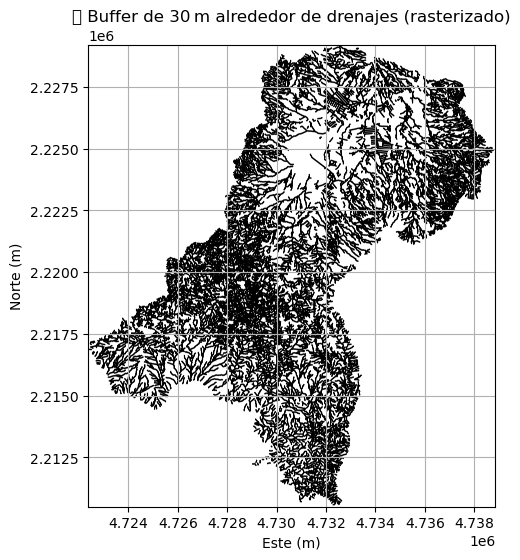

In [214]:
# Recalcular la extensión a partir de la metadata del DEM
xmin, ymax = dem_meta["transform"] * (0, 0)
xmax, ymin = dem_meta["transform"] * (dem_meta["width"], dem_meta["height"])
extent = [xmin, xmax, ymin, ymax]

# Visualización del ráster binario del buffer de drenajes
plt.figure(figsize=(8, 6))
plt.imshow(rivers_buffer_raster, cmap="gray_r", extent=extent, origin="upper")
plt.title("🛡️ Buffer de 30 m alrededor de drenajes (rasterizado)")
plt.xlabel("Este (m)")
plt.ylabel("Norte (m)")
plt.grid(True)
plt.show()



In [191]:
# 1. Buffer ribereño (30 m) – ya rasterizado en 'rivers_buffer_raster'
buffer_ribereno_mask = (rivers_buffer_raster > 0).astype("uint8")

# 2. Áreas protegidas – ráster binario 'runap' ya rasterizado
runap_path = Path.cwd() / "capas" / "rasters" / "runap.tif"
with rasterio.open(runap_path) as src:
    reservas = src.read(1)
runap_mask = (reservas > 0).astype("uint8")

# 3. Pendiente > 20% – a partir del ráster de pendiente
pendiente_mask = (pendiente > 20).astype("uint8")

# 4. Elevación > 1200 msnm – a partir del DEM
dem_path = Path.cwd() / "capas" / "DEM.tif"
with rasterio.open(dem_path) as src:
    dem = src.read(1)
elevacion_mask = (dem > 2900).astype("uint8")

# 5. Combinar todas las restricciones en una única máscara binaria
#     1 = restringido (no apto), 0 = permitido
mascara_restriccion = np.maximum.reduce([
    buffer_ribereno_mask,
    runap_mask,
    pendiente_mask,
    elevacion_mask
])

print("✅ Máscara de restricción combinada creada (1 = restringido, 0 = permitido)")

✅ Máscara de restricción combinada creada (1 = restringido, 0 = permitido)


In [193]:
print("buffer_ribereno_mask:", buffer_ribereno_mask.shape)
print("runap_mask:", runap_mask.shape)
print("pendiente_mask:", pendiente_mask.shape)
print("elevacion_mask:", elevacion_mask.shape)

buffer_ribereno_mask: (9352, 8242)
runap_mask: (9352, 8242)
pendiente_mask: (9352, 8242)
elevacion_mask: (9352, 8242)


### 3.4. Create the Combined Restriction Mask

This section generates a binary restriction mask that integrates all spatial constraints identified for mango cultivation. Each constraint is first converted to a binary raster (1 = restricted, 0 = suitable), and then combined into a single layer. 

The individual masks are merged using `np.maximum.reduce`, ensuring that any restricted pixel across the criteria is marked as restricted in the final output. The result is a binary raster where:

- `1` indicates **restricted or unsuitable** land,  
- `0` indicates **valid or permissible** land for further suitability evaluation.


✅ Máscara de restricción combinada generada (1 = restringido, 0 = permitido)
riparian_mask: (9352, 8242)
protected_areas_mask: (9352, 8242)
slope_mask: (9352, 8242)
elevation_mask: (9352, 8242)


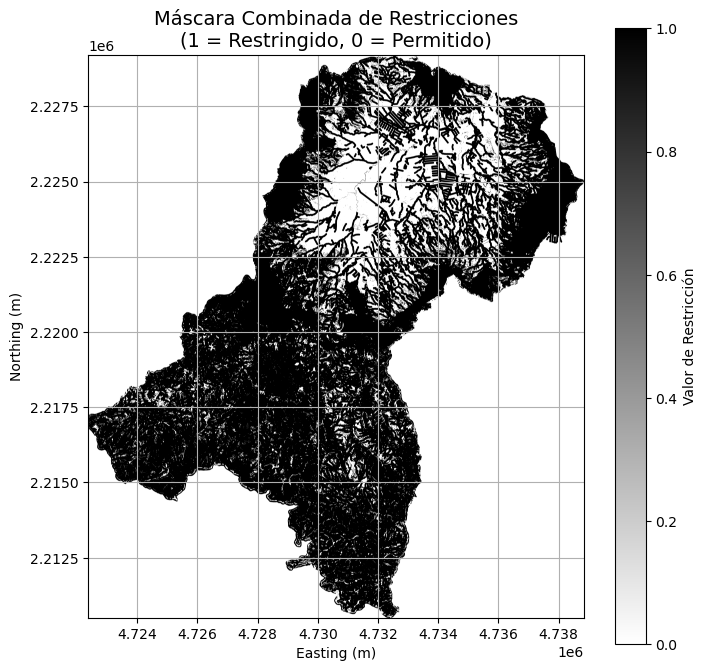

In [210]:
# Rutas
rasters_dir = Path.cwd() / "capas" / "rasters"
runap_path = rasters_dir / "runap.tif"
slope_path = rasters_dir / "pendiente.tif"
dem_path = Path.cwd() / "capas" / "DEM.tif" 

# Cargar rásters base
with rasterio.open(slope_path) as src:
    slope = src.read(1)
    transform = src.transform
    profile = src.profile

with rasterio.open(dem_path) as src:
    dem = src.read(1)

with rasterio.open(runap_path) as src:
    runap = src.read(1)

# ✅ Máscara 1: Buffer ribereño (rivers_buffer_raster debe estar previamente cargado)
riparian_mask = (rivers_buffer_raster > 0).astype("uint8")

# ✅ Máscara 2: Áreas protegidas desde RUNAP
protected_areas_mask = (runap > 0).astype("uint8")

# ✅ Máscara 3: Pendiente > 20%
slope_mask = (slope > 20).astype("uint8")

# ✅ Máscara 4: Elevación > 2900 m s.n.m.
elevation_mask = (dem > 2900).astype("uint8")

# Combinar todas las restricciones (1 = restringido, 0 = permitido)
restriction_mask = np.maximum.reduce([
    riparian_mask,
    protected_areas_mask,
    slope_mask,
    elevation_mask
])

print("✅ Máscara de restricción combinada generada (1 = restringido, 0 = permitido)")

# Verificación de formas
print("riparian_mask:", riparian_mask.shape)
print("protected_areas_mask:", protected_areas_mask.shape)
print("slope_mask:", slope_mask.shape)
print("elevation_mask:", elevation_mask.shape)

# Visualización
# Calcular la extensión usando el transform del DEM
xmin, ymax = transform * (0, 0)
xmax, ymin = transform * (restriction_mask.shape[1], restriction_mask.shape[0])
extent = [xmin, xmax, ymin, ymax]

plt.figure(figsize=(8, 8))
plt.imshow(restriction_mask, cmap="gray_r", extent=extent, origin="upper")
plt.title("Máscara Combinada de Restricciones\n(1 = Restringido, 0 = Permitido)", fontsize=14)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True)
plt.colorbar(label="Valor de Restricción")
plt.show()

## 4. Weighted sum

## 4.1. Matrices de Comparación por Pares (AHP) – Caso La Ceja (Antioquia)

Para ponderar los factores en el análisis multicriterio (SMCA), se aplica el método AHP de Saaty mediante matrices de comparación por pares. A continuación, se presentan tres enfoques:

---

### 🔹 Opción 1: Prioridad a la Pendiente (Topografía)
La pendiente es el factor más limitante debido al riesgo de erosión, dificultades de mecanización y drenaje.

| Criterio           | Pendiente | Proximidad Vías | Proximidad Ríos | AHT | Cobertura | Vocación |
|--------------------|-----------|------------------|------------------|-----|-----------|----------|
| **Pendiente**      | 1         | 5                | 5                | 3   | 3         | 3        |
| **Proximidad Vías**| 1/5       | 1                | 1                | 1   | 1         | 1        |
| **Proximidad Ríos**| 1/5       | 1                | 1                | 1   | 1         | 1        |
| **AHT**            | 1/3       | 1                | 1                | 1   | 1         | 1        |
| **Cobertura**      | 1/3       | 1                | 1                | 1   | 1         | 1        |
| **Vocación**       | 1/3       | 1                | 1                | 1   | 1         | 1        |

**Pesos resultantes** (ejemplo estimado):
- Pendiente: **0.420**
- Proximidad a Vías: **0.145**
- Proximidad a Ríos: **0.145**
- AHT: **0.095**
- Cobertura: **0.095**
- Vocación: **0.095**

---

### 🔹 Opción 2: Prioridad a la Proximidad Vial (Logística)
El acceso logístico se prioriza por la importancia del transporte hacia centros de distribución y exportación.

| Criterio           | Pendiente | Proximidad Vías | Proximidad Ríos | AHT | Cobertura | Vocación |
|--------------------|-----------|------------------|------------------|-----|-----------|----------|
| **Pendiente**      | 1         | 1/3              | 1                | 1   | 1         | 1        |
| **Proximidad Vías**| 3         | 1                | 3                | 3   | 3         | 3        |
| **Proximidad Ríos**| 1         | 1/3              | 1                | 1   | 1         | 1        |
| **AHT**            | 1         | 1/3              | 1                | 1   | 1         | 1        |
| **Cobertura**      | 1         | 1/3              | 1                | 1   | 1         | 1        |
| **Vocación**       | 1         | 1/3              | 1                | 1   | 1         | 1        |

**Pesos resultantes** (ejemplo estimado):
- Pendiente: **0.160**
- Proximidad a Vías: **0.400**
- Proximidad a Ríos: **0.120**
- AHT: **0.105**
- Cobertura: **0.105**
- Vocación: **0.105**

---

### 🔹 Opción 3: Importancia Igual (Enfoque Balanceado)
Todos los criterios se consideran igualmente importantes en el análisis.

| Criterio           | Pendiente | Proximidad Vías | Proximidad Ríos | AHT | Cobertura | Vocación |
|--------------------|-----------|------------------|------------------|-----|-----------|----------|
| **Pendiente**      | 1         | 1                | 1                | 1   | 1         | 1        |
| **Proximidad Vías**| 1         | 1                | 1                | 1   | 1         | 1        |
| **Proximidad Ríos**| 1         | 1                | 1                | 1   | 1         | 1        |
| **AHT**            | 1         | 1                | 1                | 1   | 1         | 1        |
| **Cobertura**      | 1         | 1                | 1                | 1   | 1         | 1        |
| **Vocación**       | 1         | 1                | 1                | 1   | 1         | 1        |

**Pesos resultantes**:
- Pendiente: **0.167**
- Proximidad a Vías: **0.167**
- Proximidad a Ríos: **0.167**
- AHT: **0.167**
- Cobertura: **0.167**
- Vocación: **0.167**

### 🔹 Opción 4: Ponderación Total (Modelo Mixto)
Esta opción busca un **equilibrio técnico y funcional** entre los factores del análisis, combinando criterios topográficos, logísticos y edáficos con pesos moderados. Representa el escenario final implementado en el modelo de aptitud ponderada.

| Criterio           | Pendiente | Proximidad Vías | Proximidad Ríos | AHT | Cobertura | Vocación |
|--------------------|-----------|------------------|------------------|-----|-----------|----------|
| **Pendiente**      | 1         | 2                | 2                | 2   | 2         | 2        |
| **Proximidad Vías**| 1/2       | 1                | 2                | 2   | 2         | 2        |
| **Proximidad Ríos**| 1/2       | 1/2              | 1                | 1   | 1         | 1        |
| **AHT**            | 1/2       | 1/2              | 1                | 1   | 1         | 1        |
| **Cobertura**      | 1/2       | 1/2              | 1                | 1   | 1         | 1        |
| **Vocación**       | 1/2       | 1/2              | 1                | 1   | 1         | 1        |

**Pesos resultantes** (estimación basada en implementación):
- Pendiente: **0.250**
- Proximidad a Vías: **0.200**
- Proximidad a Ríos: **0.150**
- AHT: **0.133**
- Cobertura: **0.133**
- Vocación: **0.133**

In [200]:
# 1. Rutas
rasters_dir = Path.cwd() / "capas" / "rasters"
pendiente_path = rasters_dir / "pendiente.tif"
vias_path = rasters_dir / "lvia.tif"
drenaj_l_path = rasters_dir / "drenaj_l.tif"
drenaj_r_path = rasters_dir / "drenaj_r.tif"

# Nuevas capas reclasificadas (escala 0–100)
aht_path = rasters_dir / "RECLASIFICADO_AHT_100.tif"
cobertura_path = rasters_dir / "RECLASIFICADO_COBERTURA_100.tif"
vocacion_path = rasters_dir / "RECLASIFICADO_VOCACION_100.tif"

# 2. Cargar rásters continuos
with rasterio.open(pendiente_path) as src:
    pendiente = src.read(1)
    transform = src.transform
    pixel_size = transform[0]
    profile = src.profile

with rasterio.open(vias_path) as src:
    vias = src.read(1)

with rasterio.open(drenaj_l_path) as src:
    drenaj_l = src.read(1)

with rasterio.open(drenaj_r_path) as src:
    drenaj_r = src.read(1)

# 3. Cargar capas categóricas reclasificadas (ya en escala 0–100)
with rasterio.open(aht_path) as src:
    aht_100 = src.read(1)

with rasterio.open(cobertura_path) as src:
    cobertura_100 = src.read(1)

with rasterio.open(vocacion_path) as src:
    vocacion_100 = src.read(1)

# 4. Cálculo de distancias (m)
drenajes = np.clip(drenaj_l + drenaj_r, 0, 1)
dist_vias = distance_transform_edt(vias == 0) * pixel_size
dist_drenajes = distance_transform_edt(drenajes == 0) * pixel_size

# 5. Normalización a escala 0–100
def normalizar_pendiente(array, umbral=20.0):
    clipped = np.clip(array, 0, umbral)
    return np.clip(100 * (umbral - clipped) / umbral, 0, 100)

def normalizar_proximidad(dist_array, umbral=2000.0):
    clipped = np.clip(dist_array, 0, umbral)
    return np.clip(100 * (1 - clipped / umbral), 0, 100)

pendiente_norm = normalizar_pendiente(pendiente, umbral=20)
road_proximity_norm = normalizar_proximidad(dist_vias, umbral=2000)
river_proximity_norm = normalizar_proximidad(dist_drenajes, umbral=2000)

print("✅ Factores continuos normalizados a escala 0–100.")

# 6. Asignación de pesos (puedes ajustar según AHP)
pesos_balanceado = {
    "pendiente": 1/6,
    "vias": 1/6,
    "drenajes": 1/6,
    "aht": 1/6,
    "cobertura": 1/6,
    "vocacion": 1/6
}

# 7. Cálculo de aptitud final ponderada
def calcular_aptitud_total(pesos, pendiente_n, vias_n, drenajes_n, aht_n, cobertura_n, vocacion_n):
    return (pesos["pendiente"] * pendiente_n +
            pesos["vias"] * vias_n +
            pesos["drenajes"] * drenajes_n +
            pesos["aht"] * aht_n +
            pesos["cobertura"] * cobertura_n +
            pesos["vocacion"] * vocacion_n)

aptitud_total = calcular_aptitud_total(
    pesos_balanceado,
    pendiente_norm,
    road_proximity_norm,
    river_proximity_norm,
    aht_100,
    cobertura_100,
    vocacion_100
)

print("✅ Mapa de aptitud final generado con factores continuos y categóricos.")


✅ Factores continuos normalizados a escala 0–100.
✅ Mapa de aptitud final generado con factores continuos y categóricos.


In [216]:
# Ponderación igualitaria
pesos_igual = {
    "pendiente": 1/6,
    "vias": 1/6,
    "drenajes": 1/6,
    "aht": 1/6,
    "cobertura": 1/6,
    "vocacion": 1/6
}

aptitud_igual = calcular_aptitud_total(
    pesos_igual,
    pendiente_norm,
    road_proximity_norm,
    river_proximity_norm,
    aht_100,
    cobertura_100,
    vocacion_100
)

# Ponderación con prioridad a vías
pesos_vias = {
    "pendiente": 0.1,
    "vias": 0.4,
    "drenajes": 0.1,
    "aht": 0.1,
    "cobertura": 0.15,
    "vocacion": 0.15
}

aptitud_vias = calcular_aptitud_total(
    pesos_vias,
    pendiente_norm,
    road_proximity_norm,
    river_proximity_norm,
    aht_100,
    cobertura_100,
    vocacion_100
)

# Ponderación con prioridad a pendiente
pesos_pend = {
    "pendiente": 0.4,
    "vias": 0.1,
    "drenajes": 0.1,
    "aht": 0.1,
    "cobertura": 0.15,
    "vocacion": 0.15
}

aptitud_pend = calcular_aptitud_total(
    pesos_pend,
    pendiente_norm,
    road_proximity_norm,
    river_proximity_norm,
    aht_100,
    cobertura_100,
    vocacion_100
)


In [217]:
# === Aplicar máscara de restricción combinada ===
# Zonas permitidas (restriction_mask == 0) mantienen su valor original
# Zonas restringidas (restriction_mask == 1) se asignan como -1

suit_equal_masked  = np.where(restriction_mask == 0, aptitud_igual, -1)
suit_roads_masked  = np.where(restriction_mask == 0, aptitud_vias, -1)
suit_slope_masked  = np.where(restriction_mask == 0, aptitud_pend, -1)
suit_total_masked  = np.where(restriction_mask == 0, aptitud_total, -1)  # <- nueva capa con factores mixtos

print("✅ Restricciones aplicadas a mapas de aptitud (incluido mapa total).")


✅ Restricciones aplicadas a mapas de aptitud (incluido mapa total).


## Suitability Classification and Visualisation

Once the weighted suitability scores have been calculated and the restriction mask applied, the final step in the analysis involves **classifying the continuous suitability values** (ranging from **0 to 100**) into discrete categories. This facilitates interpretation and decision-making by grouping areas into general suitability levels.

The classification scheme is as follows:

- **Restricted areas** (`-1`) are preserved and labelled as **0** (displayed in **grey**),
- **Low suitability**: values between `1` and `33` → **1** (displayed in **red**),
- **Medium suitability**: values between `34` and `66` → **2** (displayed in **yellow**),
- **High suitability**: values greater than `66` → **3** (displayed in **green**).

This classification is applied to the following four suitability scenarios:

1. **Equal importance** among all factors,  
2. **Priority given to proximity to roads**,  
3. **Priority given to slope suitability**,  
4. **Overall weighted combination of factors** (mixed model).

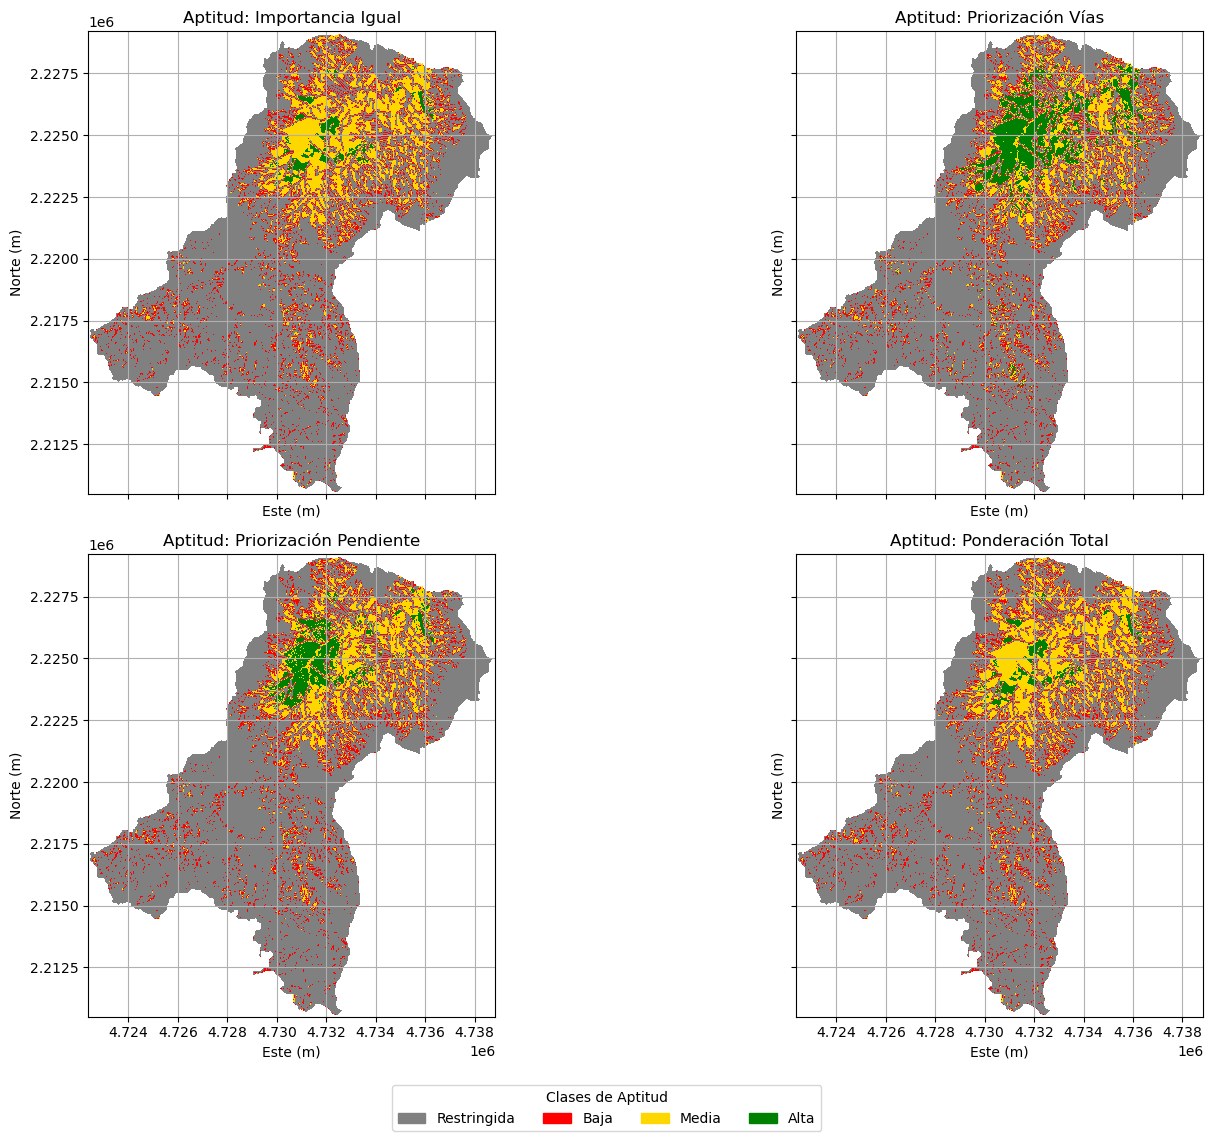

In [236]:
# === Clasificación de aptitud en La Ceja (Antioquia) ===

def clasificar_aptitud(array_masked):
    """
    Clasifica los valores de aptitud (rango 0–100) en 3 niveles discretos:
    1 = Baja, 2 = Media, 3 = Alta. Las zonas restringidas (valor -1) se conservan como 0.
    """
    clasificado = np.full_like(array_masked, 0)  # 0 = zona restringida
    clasificado[(array_masked > 0) & (array_masked <= 33)] = 1
    clasificado[(array_masked > 33) & (array_masked <= 66)] = 2
    clasificado[(array_masked > 66)] = 3
    return clasificado

# Aplicar clasificación a los cuatro escenarios
aptitud_igual_clasificada = clasificar_aptitud(suit_equal_masked)
aptitud_vias_clasificada = clasificar_aptitud(suit_roads_masked)
aptitud_pendiente_clasificada = clasificar_aptitud(suit_slope_masked)
aptitud_total_clasificada = clasificar_aptitud(suit_total_masked)

# === Aplicar máscara AOI para ocultar fondo ===
from rasterio.features import rasterize
import geopandas as gpd

aoi_path = Path.cwd() / "capas" / "aoi.shp"
gdf_aoi = gpd.read_file(aoi_path).to_crs(profile["crs"])
aoi_mask = rasterize(
    [(geom, 1) for geom in gdf_aoi.geometry],
    out_shape=aptitud_total.shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# Aplicar máscara AOI: fuera del AOI = np.nan
aptitud_igual_clasificada = np.where(aoi_mask == 1, aptitud_igual_clasificada, np.nan)
aptitud_vias_clasificada = np.where(aoi_mask == 1, aptitud_vias_clasificada, np.nan)
aptitud_pendiente_clasificada = np.where(aoi_mask == 1, aptitud_pendiente_clasificada, np.nan)
aptitud_total_clasificada = np.where(aoi_mask == 1, aptitud_total_clasificada, np.nan)

# === Visualización con grilla ===
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Configuración de colores y clases
class_cmap = ListedColormap(["grey", "red", "gold", "green"])  # 0, 1, 2, 3
class_labels = ["Restringida", "Baja", "Media", "Alta"]
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(boundaries, class_cmap.N)

# Crear figura con subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)

# Mapa 1: Importancia Igual
axs[0, 0].imshow(aptitud_igual_clasificada, cmap=class_cmap, norm=norm, extent=extent, origin="upper")
axs[0, 0].set_title("Aptitud: Importancia Igual")
axs[0, 0].set_xlabel("Este (m)")
axs[0, 0].set_ylabel("Norte (m)")
axs[0, 0].grid(True)

# Mapa 2: Priorización Vías
axs[0, 1].imshow(aptitud_vias_clasificada, cmap=class_cmap, norm=norm, extent=extent, origin="upper")
axs[0, 1].set_title("Aptitud: Priorización Vías")
axs[0, 1].set_xlabel("Este (m)")
axs[0, 1].set_ylabel("Norte (m)")
axs[0, 1].grid(True)

# Mapa 3: Priorización Pendiente
axs[1, 0].imshow(aptitud_pendiente_clasificada, cmap=class_cmap, norm=norm, extent=extent, origin="upper")
axs[1, 0].set_title("Aptitud: Priorización Pendiente")
axs[1, 0].set_xlabel("Este (m)")
axs[1, 0].set_ylabel("Norte (m)")
axs[1, 0].grid(True)

# Mapa 4: Ponderación Total
axs[1, 1].imshow(aptitud_total_clasificada, cmap=class_cmap, norm=norm, extent=extent, origin="upper")
axs[1, 1].set_title("Aptitud: Ponderación Total")
axs[1, 1].set_xlabel("Este (m)")
axs[1, 1].set_ylabel("Norte (m)")
axs[1, 1].grid(True)

# Leyenda común
leyenda = [Patch(color=class_cmap(i), label=label) for i, label in enumerate(class_labels)]
fig.legend(handles=leyenda, loc='lower center', ncol=4, title="Clases de Aptitud", fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


## Final Suitability Assessment – SMCA Results for Hass Avocado in *La Ceja, Antioquia*

The following maps represent four spatial multi-criteria scenarios for Hass avocado suitability in *La Ceja*, each incorporating environmental, topographic, and logistical factors, with applied constraints. The restricted areas (in grey) have been masked based on legal, physical, and ecological exclusion zones.

### Comparative Conclusions by Weighting Scenario

#### **Scenario 1: Equal Importance**
- Shows a **balanced distribution** between low (red), medium (yellow), and high (green) suitability.
- High suitability areas are present but more **fragmented**.
- Serves as a **neutral baseline** without favoring any particular criterion.

#### **Scenario 2: Priority to Road Proximity**
- High suitability zones **expand** significantly in the northern region, closely aligned with road networks.
- Confirms that **access to road infrastructure** has a strong impact on potential suitability.

#### **Scenario 3: Priority to Slope**
- Displays well-defined but **slightly more dispersed** green areas.
- Medium suitability spreads further into the southwest, likely due to terrain conditions.
- Ideal for prioritizing **terrain stability** and minimizing erosion risk.

#### **Scenario 4: Total Weighted Combination (Mixed Model)**
- Provides a **balanced synthesis** of land, soil, terrain, and accessibility.
- Shows **compact and concentrated high suitability zones** in the central-northern sector.
- Offers the **most realistic and technically sound** option for spatial planning.

### General Summary

- All high suitability zones concentrate primarily in the **northern part of La Ceja**, in areas with moderate slope, agricultural land cover, and good accessibility.
- **Constraints** (grey areas) exclude a large portion of the territory, allowing for more **precise targeting**.
- The **Total Weighted scenario** is recommended for decision-making and territorial planning, as it integrates physical, ecological, and logistical considerations in a balanced manner.
